#Deblurring di immagini mosse

Il progetto riguarda il deblurirng di immagini. Il tipo di "blur" in questione è ottenuto mediante sovrapposizione di immagini leggermente traslate a partire dall'originale, lungo un tragitto randomico.

Questo tipo di blur ntende simulare il risultato del tremolio della mano per riprese con tempo di esposizione prolungato.

In [1]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, UpSampling2D, Concatenate, Resizing, Conv2DTranspose
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math

Lavoriamo da immagini ottenute a partire da MNIST.

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = (x_train/255.).astype(np.float32)
x_test = (x_test/255.).astype(np.float32)

11490434/11490434 [==============================] - 0s 0us/step


Qui viene fornito il generatore che dovete utilizzare per il vostro progetto.
Non modificate in numero di mosse (10), nè il range della traslazione.

Siete liberi di modificare a piacimento la batchsize. Utilizzate x_train per il training e x_valid per la validazione.

In [3]:
def generator(dataset,batchsize,moves=10):
  while True:
    rand = np.random.randint(dataset.shape[0],size=batchsize)
    y_truth = dataset[rand]
    blurred = np.copy(y_truth)
    moving = tf.expand_dims(y_truth,axis=-1)

    for i in range(moves):
      #RandomTranslation requires a channel axis
      moving = layers.RandomTranslation(0.07,0.07,fill_mode='constant',interpolation='bilinear')(moving)
      blurred = blurred + tf.squeeze(moving)
    blurred = blurred/(moves+1)
    yield(blurred,y_truth)


In [4]:
my_gen = generator(x_train,5)

In [5]:
def plot(x,y):
  no = x.shape[0]
  print(no)
  plt.figure(figsize=(2*no, 4))
  for i in range(no):
    # display original
    ax = plt.subplot(2, no, i + 1)
    plt.imshow(x[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, no, i + 1 + no)
    plt.imshow(y[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.show()

Qui potete vedere alcuni esempi restituiti dal generatore
Here we plot some examples. In the first row you see the blurred image, and in the second the original image, that is the ground truth that you are suppose to obtain through deblurring.

5


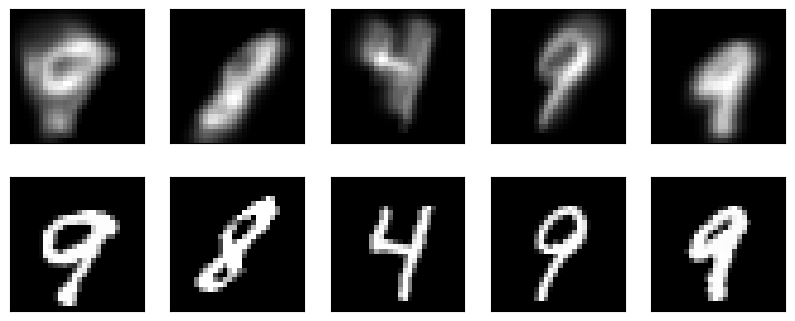

In [6]:
test_x,test_y = next(my_gen)
plot(test_x,test_y)

# Valutazione

Utilizzate Mean Squared Error (mse) per valutare l'errore tra l'immagine deblurred e la ground truth.

Misurate l' mse su 10000 immagini blurred ottenute dal validation set.

Ripetete la computazione precedente per 10 volte, e fornite come risutato la
**media dei 10 round, unitamente alla deviazione standard**.


# Cosa consegnare
Il lavoro deve essere scolto in keras/tensorflow. Consegnate un singolo notebook dove dovete conservare traccia del training.

Discutete e motivate l'architettura finale, cosi come la scelta dei principali iperparametri.

#Svolgimento

## Iperparametri
Dopo vari tentativi questi sono gli iperparametri:
* batch size = 24
* epoche = 50. In realtà spesso si ferma prima per evitare overfitting, grazie all'early stopping.
* lr: sono stati molti i tentativi per trovare il learning rate migliore. Alla fine la soluzione più semplice è stata quella di adattarlo durante il training, facendolo partire da un valore alto (0.001) e riducendolo seguendo lo schema dello Step Decay. Vedere la sezione sul training.

In [7]:
BATCH_SIZE = 24
TRAIN_RATIO = 0.9   #percentuale Train sull'intero dataset
EPOCHS = 50

#LR_Schedule
LR_start = 1e-3
DECAY_FACTOR = 0.75
STEP_LR = 4

OPTIMIZER = tf.keras.optimizers.legacy.Adam(learning_rate = LR_start)



## Creazione del Dataset
Uso il generatore su tutto il trainset, in modo da avere tutte le immagini in tempi molto brevi. Fare diversamente (chiamare il generatore più volte su un batch size minore oppure usare il generatore direttamente nel fit del modello) comporterebbe l'aumento di tempo per l'esecuzione delle operazioni.

In [8]:
#divisione train/validation
train_x, validation_x, train_y, validation_y = train_test_split(x_train, y_train, test_size = (1-TRAIN_RATIO), shuffle=True);

#generazione dei dataset
train_x, train_y = next(generator(train_x, train_x.shape[0]));
validation_x, validation_y = next(generator(validation_x, validation_x.shape[0]));
generator_test = generator(x_test, BATCH_SIZE);

print(train_x.shape, validation_x.shape)

(54000, 28, 28) (6000, 28, 28)


## Costruzione del modello
Modello che prende ispirazione dalla UNet, sono disponibili più informazioni nel commento inserito.

In [9]:
def down_block(inputs, filters, kernel_size=(3, 3), padding='same', activation='relu'):
    conv = Conv2D(filters, kernel_size, activation=activation, padding=padding)(inputs)
    conv = BatchNormalization()(conv)
    conv = Conv2D(filters, kernel_size, activation=activation, padding=padding)(conv)
    conv = BatchNormalization()(conv)
    pool = MaxPooling2D(pool_size=(2, 2))(conv)
    return conv, pool

def up_block(inputs, skip, filters, kernel_size=(3, 3), padding='same', activation='relu'):
    up = UpSampling2D(size=(2, 2))(inputs)
    concat = Concatenate()([up, skip])
    conv = Conv2D(filters, kernel_size, activation=activation, padding=padding)(concat)
    conv = BatchNormalization()(conv)
    conv = Conv2D(filters, kernel_size, activation=activation, padding=padding)(conv)
    conv = BatchNormalization()(conv)
    return conv


#input
encoder_input = layers.Input(shape = (28,28,1))

#resize
res_input = Resizing(height = 56, width = 56, crop_to_aspect_ratio = True)(encoder_input)

#encoder
conv1, pool1 = down_block(res_input, 32)
conv2, pool2 = down_block(pool1, 64)
conv3, pool3 = down_block(pool2, 128)

#bottleneck
conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
conv4 = BatchNormalization()(conv4)
conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
conv4 = BatchNormalization()(conv4)

#decoder
conv5 = up_block(conv4, conv3, 128)
conv6 = up_block(conv5, conv2, 64)
conv7 = up_block(conv6, conv1, 32)


#output
decoded = layers.Conv2D(1,(3,3), activation='sigmoid', padding='same')(conv7)

#resize
res_output = Resizing(height = 28, width = 28, crop_to_aspect_ratio = True)(decoded)

model = Model(encoder_input, res_output, name="DUNet")

model.summary()

Model: "DUNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 resizing (Resizing)         (None, 56, 56, 1)            0         ['input_1[0][0]']             
                                                                                                  
 conv2d (Conv2D)             (None, 56, 56, 32)           320       ['resizing[0][0]']            
                                                                                                  
 batch_normalization (Batch  (None, 56, 56, 32)           128       ['conv2d[0][0]']              
 Normalization)                                                                               

## Training

Per evitare l'overfitting utilizzo l'Early Stopping: dopo 5 epoche in cui non c'è miglioramento sulla loss dei dati di validazione il training termina.

Per aggiustare il LearningRate durante il training, utilizzo lo Step Decay
Schedule, ovvero il learning rate viene moltiplicato con un fattore 0*75 ogni 4 epoche. Questo creerà una discesa del learning rate a scalino. Questo serve per migliorare le performance e ridurre il tempo di training.



In [10]:
#definizione callback
es = EarlyStopping(monitor='val_loss', mode='min', patience=5)

def step_decay_schedule(initial_lr, decay_factor, step_size):
    def schedule(epoch):
        return initial_lr * (decay_factor ** np.floor(epoch/step_size))

    return LearningRateScheduler(schedule)

lr_sched = step_decay_schedule(initial_lr=LR_start, decay_factor=DECAY_FACTOR, step_size=STEP_LR)

# Compila il modello
model.compile(optimizer=OPTIMIZER, loss='mse')

#training
history = model.fit(train_x, train_y, batch_size = BATCH_SIZE, epochs = EPOCHS,  validation_data = (validation_x, validation_y), callbacks = [es, lr_sched])

Epoch 1/50
2250/2250 [==============================] - 75s 30ms/step - loss: 0.0109 - val_loss: 0.0063 - lr: 0.0010
Epoch 2/50
2250/2250 [==============================] - 68s 30ms/step - loss: 0.0042 - val_loss: 0.0047 - lr: 0.0010
Epoch 3/50
2250/2250 [==============================] - 68s 30ms/step - loss: 0.0034 - val_loss: 0.0033 - lr: 0.0010
Epoch 4/50
2250/2250 [==============================] - 67s 30ms/step - loss: 0.0029 - val_loss: 0.0043 - lr: 0.0010
Epoch 5/50
2250/2250 [==============================] - 67s 30ms/step - loss: 0.0023 - val_loss: 0.0026 - lr: 7.5000e-04
Epoch 6/50
2250/2250 [==============================] - 67s 30ms/step - loss: 0.0021 - val_loss: 0.0023 - lr: 7.5000e-04
Epoch 7/50
2250/2250 [==============================] - 67s 30ms/step - loss: 0.0020 - val_loss: 0.0022 - lr: 7.5000e-04
Epoch 8/50
2250/2250 [==============================] - 66s 29ms/step - loss: 0.0018 - val_loss: 0.0021 - lr: 7.5000e-04
Epoch 9/50
2250/2250 [==========================

##Visualizzazione della loss

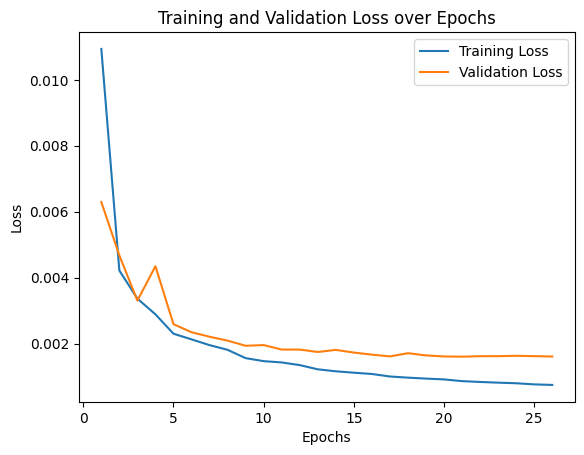

In [11]:
def plot_loss(history):
    # Estrai i valori della loss dalle epoche
    training_loss = history.history['loss']

    # Estrai i valori della validation loss dalle epoche
    validation_loss = history.history.get('val_loss', None)

    # Numero totale di epoche
    epochs = range(1, len(training_loss) + 1)

    # Plot della loss di addestramento
    plt.plot(epochs, training_loss, label='Training Loss')

    # Se validation loss è disponibile, aggiungilo al plot
    if validation_loss is not None:
        plt.plot(epochs, validation_loss, label='Validation Loss')

    plt.title('Training and Validation Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


plot_loss(history)

## Visualizzazione dei dati predetti


1/1 [==============================] - 0s 70ms/step
5


<Figure size 3000x600 with 0 Axes>

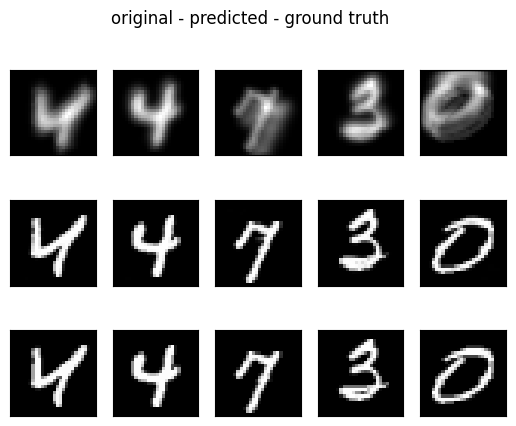

In [22]:
def plot_preview(x,y,z):
  no = x.shape[0]
  print(no)
  plt.figure(figsize=(3*no, 6))
  fig, axs = plt.subplots(3, no)
  fig.suptitle('original - predicted - ground truth')

  for i in range(no):
    # display original
    axs[0,i].imshow(x[i])
    plt.gray()
    axs[0,i].get_xaxis().set_visible(False)
    axs[0,i].get_yaxis().set_visible(False)

    # display reconstruction
    axs[1,i].imshow(y[i])
    plt.gray()
    axs[1,i].get_xaxis().set_visible(False)
    axs[1,i].get_yaxis().set_visible(False)

    # display ground truth
    axs[2,i].imshow(z[i])
    plt.gray()
    axs[2,i].get_xaxis().set_visible(False)
    axs[2,i].get_yaxis().set_visible(False)

  plt.show()


test_x,test_y = next(my_gen)

plot_preview(test_x,  model.predict(test_x), test_y)

##Valutazione del modello

In [23]:
steps_test = math.ceil(x_test.shape[0] / BATCH_SIZE)

mse_scores = []

for _ in range(10):
    mse = model.evaluate(generator_test, steps = steps_test)
    mse_scores.append(mse)

# Calcola la media e la deviazione standard
mean_mse = np.mean(mse_scores)
std_mse = np.std(mse_scores)

print(f'Mean MSE: {mean_mse}, Std MSE: {std_mse}')


417/417 [==============================] - 59s 143ms/step - loss: 0.0016
Mean MSE: 0.0015716472291387618, Std MSE: 2.9325837341369214e-05


##Commento
Sono partito dal costruire un autoencoder composto da:
* 2 blocchi di encoding, formati da un Conv2D, BatchNormalization e un MaxPool2D
* 2 blocchi di decoding, con UpSampling2D, simmetrici all'encoding.

Con questo modello, facendo vari test modificando gli iperparametri, sono passato da un MSE di 0.02760 ad uno con MSE di 0.01461931448429823.
Gli iperparametri utilizzati in questa prima versione erano condizionati dalle poche epoche. Infatti il numero di epoche nei primi training è stato molto basso per errore sulla generazione del dataset.

Nonostante molte modifiche alla rete, il miglioramento non era eccessivo. Dunque la soluzione è stata quella di cambiare modello, partendo da questo ma aggiungendo skip connection, e avendo come ispirazione la UNet.


E' stato notato subito un miglioramento, tuttavia ero impossibilitato nell'inserire più di due blocchi di discesa/salita. Questo perchè, dopo due MaxPool, l'immagine aveva shape 7x7x..., il che impediva di scendere utleriormente.

L'idea è quindi stata quella di rendere l'immagine da 28x28 a 56x56, sfruttando il layer "Resizing" di keras e cercando di perdere meno informazioni possibili dall'immagine di partenza. Usando questo metodo e in seguito a molti tentativi sono arrivato alla realizzazione di questo modello:

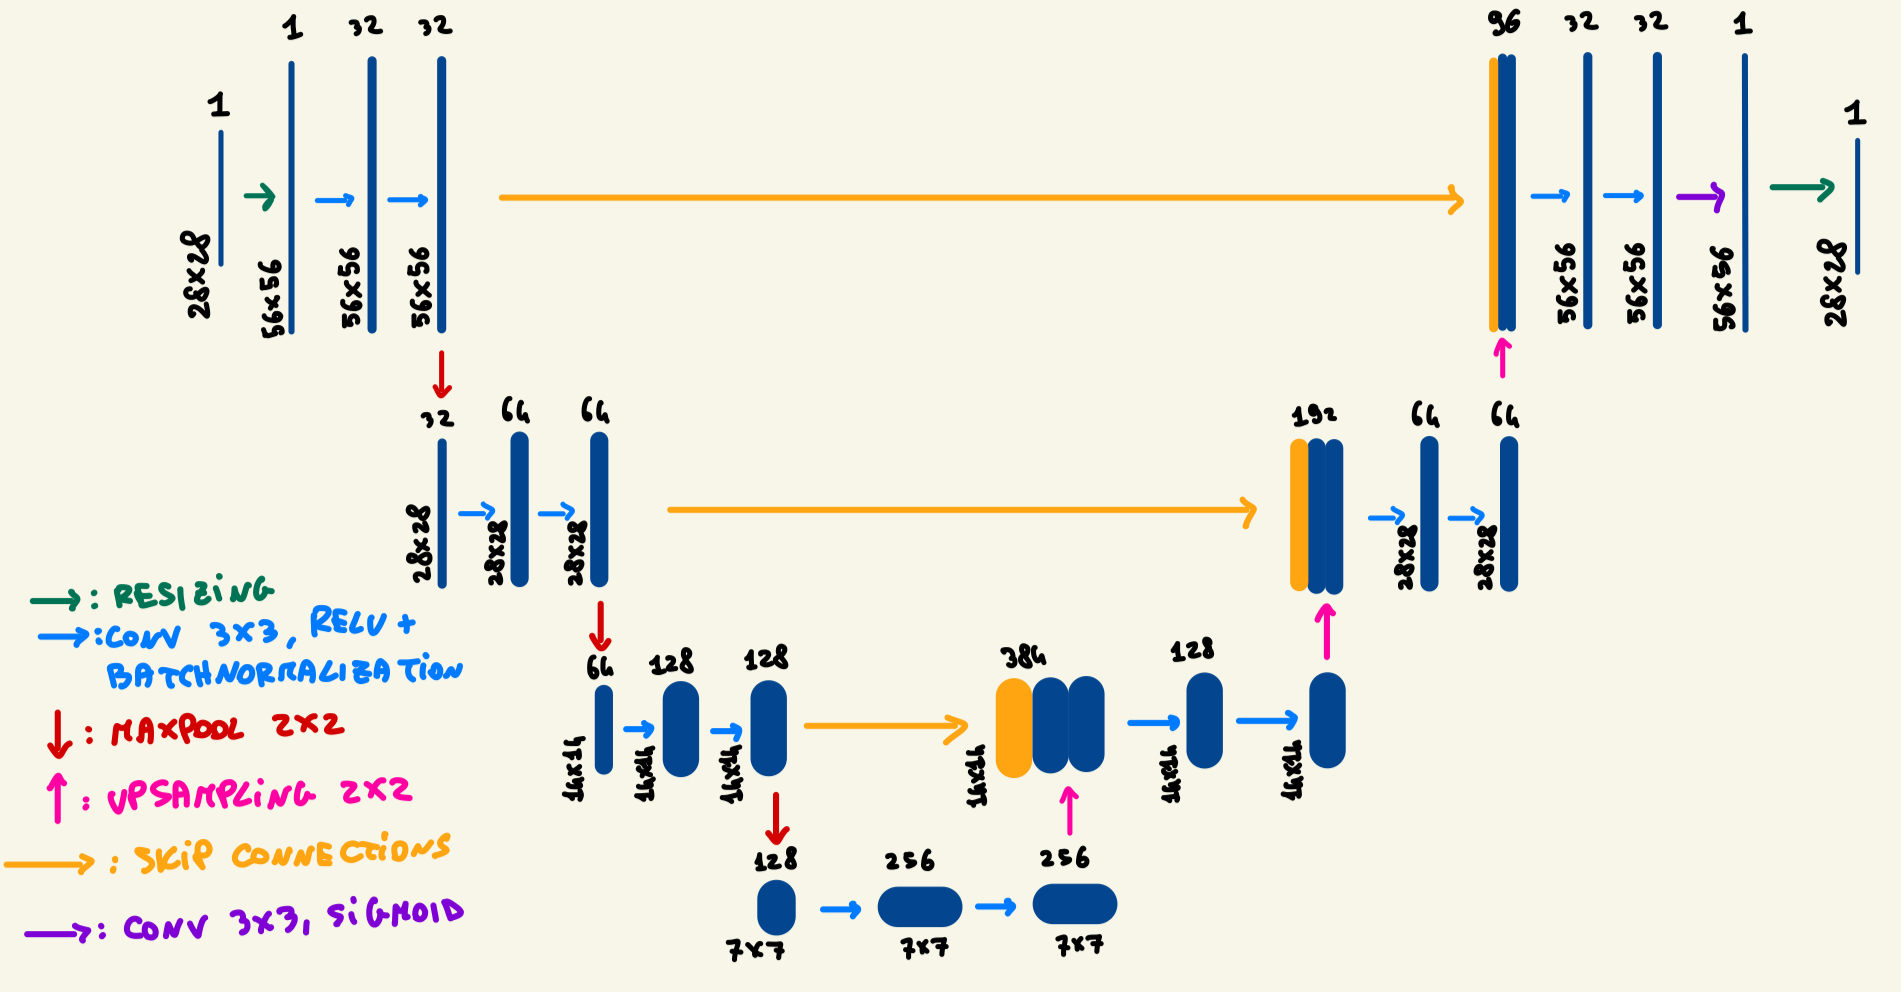

Sono state effettuate anche prove cambiano l'UpSampling layer con un Conv2DTranspose, che dovrebbe risultare in una performance migliore ma nella pratica non si è visto.

I batchNormalization Layer migliorano di molto la prestazione della rete quindi sono stati aggiunti un po' ovunque in corrisponenza di un Conv2D.

Per quanto riguarda gli iperparametri, sono scritti nella sezione apposita.